# Assignment 4: Neural Networks and Deep Learning
# Fredy Díaz & Oscar Perdomo

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import caffe as cf
import os
from scipy.special import expit as sigmoid
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import scipy.optimize
import sample_images
import sparse_RICA
import gradient
import display_network
import load_MNIST

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 13 days


## 1. Consider the neural network presented in the item 1 of assign4:

In [2]:
def relu(x):
    return np.maximum(x, 0)

def reluPrime(x):
    return 1.0 * (x >= 0)

def sigmoidPrime(x):
    sigma = sigmoid(x)
    return np.multiply(sigma, np.subtract(1, sigma))

def costFunction(mlp, X, y):
    cost = 0.0
    samples = X.shape[0]
    
    for i in range(samples):
        cost += (mlp.forward(X[i, :])[0] - y[i]) ** 2
    
    cost = 1.0/(2.0 * samples) * cost
    
    return cost

In [3]:
class MLP():
    T = None
    W = None
    functions = None
    pFunctions = None
    
    def __init__(self, neurons, functions, pFunctions):
        self.W = np.zeros((neurons, neurons))
        self.T = np.zeros((neurons, neurons))
        self.functions = functions
        self.pFunctions = pFunctions
    
    def forward(self, x):
        a = self.weightedSums(x)
        z = self.applyFunctions(a, self.functions)
        
        return z
    
    def weightedSums(self, x):
        neurons = self.W.shape[0]
        a = np.zeros(neurons)
        a[self.getInputNeurons()] = x
        
        for i in range(neurons):
            a = np.dot(self.applyFunctions(a, self.functions), self.W)
        
        return a
    
    def delta(self, x, y):
        neurons = self.W.shape[0]
        a = self.weightedSums(x)
        z = self.applyFunctions(a, self.functions)
        fp = self.applyFunctions(a, self.pFunctions)
        delta = np.zeros(neurons)
        
        for i, j in enumerate(self.getOuputNeurons()):
            # Calculate the output neurons errors
            delta[j] = (z[j] - y[i]) * fp[j]
        
        for i in self.getHiddenNeurons():
            delta[i] = np.multiply(np.dot(delta, self.W.T), fp)[i]
            
        return delta
    
    def update(self, x, y, alpha):
        z = self.forward(x)
        delta = self.delta(x, y)
        G = np.multiply(np.outer(z, delta), self.T)
        self.W = np.subtract(self.W, alpha * G)
        
    def fit(self, X, y, alpha, epochs, costFunction):
        samples = X.shape[0]
        idx = np.random.permutation(np.arange(samples))
        cost = []
        for i in range(epochs):
            for i in np.random.permutation(np.arange(samples)):
                self.update(X[i, :], y[i:i+1], alpha)
                cost.append(costFunction(self, X, y))
                
        return cost
    
    def setLink(self, start, end, w):
        self.W[start, end] = w
        self.T[start, end] = 1
        
    def applyFunctions(self, a, functions):
        neurons = self.W.shape[0]
        z = np.zeros(neurons)
        
        for i in range(neurons):
            z[i] = functions[i](a[i])
            
        return z
    
    def getOuputNeurons(self):
        return np.where(~self.T.any(axis=1))[0]
    
    def getHiddenNeurons(self):
        notOuput = np.where(self.T.any(axis=1))[0]
        return np.setdiff1d(notOuput, self.getInputNeurons())
    
    def getInputNeurons(self):
        return np.where(np.diagonal(self.T) == 1)[0]

In [4]:
neurons = 5
epsilon = 0.12
functions = [sigmoid, relu, sigmoid, sigmoid, lambda x : x]
pfunctions = [sigmoidPrime, reluPrime, sigmoidPrime, sigmoidPrime, lambda x : x]

### (a) Write a function to simulate the neural network.

Using the previous class, we create the architecture of the neural network:

In [5]:
mlpA = MLP(neurons, functions, pfunctions)
mlpA.setLink(1, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpA.setLink(2, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpA.setLink(3, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpA.setLink(2, 1, np.random.uniform(low=-epsilon, high=epsilon))
mlpA.setLink(3, 1, np.random.uniform(low=-epsilon, high=epsilon))
mlpA.setLink(4, 2, np.random.uniform(low=-epsilon, high=epsilon))
mlpA.setLink(4, 3, np.random.uniform(low=-epsilon, high=epsilon))
mlpA.setLink(4, 4, 1.0)

Finally, we simulate the neural network using the method forward:

In [6]:
outputs = mlpA.forward(np.array([1.0]))

The outputs of each neuron are:

In [7]:
pd.DataFrame(np.matrix([outputs]), columns=["$z_1$", "$z_2$", "$z_3$", "$z_4$", "$z_5$"])

,$z_1$,$z_2$,$z_3$,$z_4$,$z_5$
0,0.488506,0.018178,0.518008,0.504847,1


### (b) Deduce the equations to calculate $\delta_{i}$ (the error value per neuron) for all the neurons. Write a function that given a training sample and the weights of the network calculate $\delta_{i}$ for each neuron.

Taking into account the next expressions.

* The first derivate of the sigmoid function is calculated as follows:

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

$$\sigma'(x)=\sigma(x)-\sigma(x)^{2} = \sigma(x) (1-\sigma(x))$$

* The weighted sum for each neuron $n$ is calculated as follows. Bear in ind, that $W$ is the weights matrix for the network, so each column contains the weights for a neuron and $a$ is a row vector that contains the outputs of all neurons after the forward process:

$$a_{n} = z \cdot W^{n}$$

$$z_{n}=\sigma(z \cdot W^{n}) = \sigma(a_{n})$$

* We calculate the cost function in the output neuron over an example as follows. Note, that $r^{t}$ is the expected output value of the neuron $z_{1}$: 

$$E=\frac{1}{2}[z_{1}-r]^{2}$$

* Then, for each neuron we calculate the error $\delta_{j}$ as:

$$\delta_{j}=\frac{\partial E}{\partial a_{j}}$$

Taking into account the previous expressions we can calculate the error as follow:

* We calculate the error for the output neuron ($n=1$) $\delta_{1}$ as:

$$\delta_{1}(x)=\frac{\partial E}{\partial a_{1}}=(z_{1}-r)f_{1}'(a_{1})$$

* We calculate the error for neuron 2 $\delta_{2}$ as:

$$\delta_{2}(x)=\frac{\partial E}{\partial a_{2}}=(z_{1}-r)\frac{\partial}{\partial a_{2}}f_{1}(a_{1})=(z_{1}-r)f_{1}'(a_{1})\frac{\partial}{\partial a_{2}}z_{2}W_{2}^{1}=\delta_{1}(x)W_{2}^{1}f_{2}'(a_{2})$$

* We calculate the error for neuron 3 $\delta_{3}$ as:

$$\delta_{3}(x)=\frac{\partial E}{\partial a_{3}}=(z_{1}-r)f'(z_{1})\frac{\partial}{\partial a_{3}}zW^{1}=\delta_{1}(x)\frac{\partial}{\partial a_{3}}[z_{2}W_{2}^{1}+z_{3}W_{3}^{1}]=\delta_{1}(x)W_{2}^{1}f_{2}'(a_{2})\frac{\partial}{\partial a_{3}}z_{3}W_{3}^{2}+\delta_{1}(x)W_{3}^{1}f_{3}'(a_{3})=\delta_{1}(x)W_{2}^{1}f_{2}'(a_{2})W_{3}^{2}f_{3}'(a_{3})+\delta_{1}(x)W_{3}^{1}f_{3}'(a_{3})=\delta_{2}(x)W_{3}^{2}f_{3}'(a_{3})+\delta_{1}(x)W_{3}^{1}f_{3}'(a_{3})$$

* We calculate the error for neuron 4 $\delta_{4}$ as:

$$\delta_{4}(x)=\frac{\partial E}{\partial a_{4}}=(z_{1}-r)f_{1}'(a_{1})\frac{\partial}{\partial a_{4}}[z_{2}W_{2}^{1}+z_{4}W_{4}^{1}]=\delta_{1}(x)W_{2}^{1}f_{2}'(a_{2})\frac{\partial}{\partial a_{4}}a_{2}+\delta_{1}(x)W_{4}^{1}f_{4}'(a_{4})=\delta_{2}(x)\frac{\partial}{\partial a_{4}}z_{4}W_{4}^{2}+\delta_{1}(x)W_{4}^{1}f_{4}'(a_{4})=\delta_{2}(x)W_{4}^{2}f_{4}'(a_{4})+\delta_{1}(x)W_{4}^{1}f_{4}'(a_{4})$$

Using the previous expressions, we implement the function that calculates the errors in all neurons (hidden and output) over a samples set. Check the deltas method in MLP class:

In [8]:
pd.DataFrame(np.matrix([mlpA.delta(np.array([1.]), np.array([1.1]))]), columns=["$\delta_1$", "$\delta_2$", "$\delta_3$", "$\delta_4$", "$\delta_5$"])

,$\delta_1$,$\delta_2$,$\delta_3$,$\delta_4$,$\delta_5$
0,-0.152793,-0.005787,0.001833,0.001595,0


### (c) Assuming the weight matrix presented in the assign specification, use the functions from items (a) and (b) to calculate the output of each neuron, $z_{i}$, and the error, $\delta_{i}$, for the following training samples:

We calculate the gradient as follows:

$$\nabla W_{j}^{i}(x)=\frac{\partial E}{\partial W_{j}^{i}}=\frac{\partial E}{\partial a_{i}}\frac{\partial a_{i}}{\partial W_{j}^{i}}=\delta_{i}(x)z_{j}$$

In [9]:
mlpC = MLP(neurons, functions, pfunctions)
mlpC.setLink(1, 0, 3.0)
mlpC.setLink(2, 0, -4.0)
mlpC.setLink(3, 0, -1.0)
mlpC.setLink(2, 1, 1.0)
mlpC.setLink(3, 1, -3.0)
mlpC.setLink(4, 2, 2.0)
mlpC.setLink(4, 3, -10.0)
mlpC.setLink(4, 4, 1.0)

Next, we calculate the output of each neuron and their errors for the following samples:

In [10]:
X1 = np.array([[0.], [1.]])
pd.DataFrame(np.matrix([mlpC.forward(X1[0]), mlpC.forward(X1[1])]), columns=["$z_1$", "$z_2$", "$z_3$", "$z_4$", "$z_5$"])

,$z_1$,$z_2$,$z_3$,$z_4$,$z_5$
0,0.075858,0.000000,0.500000,0.500000,0
1,0.292919,0.880661,0.880797,0.000045,1


In [11]:
y1 = np.array([0.5, 0.1])
pd.DataFrame(y1, columns=["$y$"])

,$y$
0,0.5
1,0.1


In [12]:
pd.DataFrame(np.matrix([mlpC.delta(X1[0], y1[0:1])]), columns=["$\delta_1$", "$\delta_2$", "$\delta_3$", "$\delta_4$", "$\delta_5$"])

,$\delta_1$,$\delta_2$,$\delta_3$,$\delta_4$,$\delta_5$
0,-0.029734,-0,0.029734,0.007433,0


In [13]:
pd.DataFrame(np.matrix([mlpC.delta(X1[1], y1[1:2])]), columns=["$\delta_1$", "$\delta_2$", "$\delta_3$", "$\delta_4$", "$\delta_5$"])

,$\delta_1$,$\delta_2$,$\delta_3$,$\delta_4$,$\delta_5$
0,0.039957,0.11987,-0.004195,-0.000018,0


### (d) Write a function to train the neural network using stochastic gradient descent.

For the training process, we use the fit method from MLP class, please check that method for the details.

### (e) Use the function to train the network with the following training samples. Plot the evolution of the error and the predictions of the trained network. Write down the weights of the trained network:

In [14]:
XT = np.array([[-3],[-2.95],[-2.9],[-2.85],[-2.8],[-2.75],[-2.7],[-2.65],[-2.6],[-2.55],[-2.5],[-2.45],[-2.4],[-2.35],[-2.3],[-2.25],[-2.2],[-2.15],[-2.1],[-2.05],[-2],[-1.95],[-1.9],[-1.85],[-1.8],[-1.75],[-1.7],[-1.65],[-1.6],[-1.55],[-1.5],[-1.45],[-1.4],[-1.35],[-1.3],[-1.25],[-1.2],[-1.15],[-1.1],[-1.05],[-1],[-0.95],[-0.9],[-0.85],[-0.8],[-0.75],[-0.7],[-0.65],[-0.6],[-0.55],[-0.5],[-0.45],[-0.4],[-0.35],[-0.3],[-0.25],[-0.2],[-0.15],[-0.1],[-0.05],[0],[0.05],[0.1],[0.15],[0.2],[0.25],[0.3],[0.35],[0.4],[0.45],[0.5],[0.55],[0.6],[0.65],[0.7],[0.75],[0.8],[0.85],[0.9],[0.95],[1],[1.05],[1.1],[1.15],[1.2],[1.25],[1.3],[1.35],[1.4],[1.45],[1.5],[1.55],[1.6],[1.65],[1.7],[1.75],[1.8],[1.85],[1.9],[1.95],[2],[2.05],[2.1],[2.15],[2.2],[2.25],[2.3],[2.35],[2.4],[2.45],[2.5],[2.55],[2.6],[2.65],[2.7],[2.75],[2.8],[2.85],[2.9],[2.95],[3],[3.05],[3.1],[3.15],[3.2],[3.25],[3.3],[3.35],[3.4],[3.45]])
yT = np.array([0.731204119, 0.731227664, 0.731255017, 0.731286793, 0.731323706, 0.731366586, 0.731416396, 0.731474254, 0.731541459, 0.731619517, 0.731710176, 0.731815465, 0.731937737, 0.73207972, 0.732244579, 0.732435978, 0.732658165, 0.732916056, 0.733215342, 0.733562604, 0.733965444, 0.734432642, 0.734974322, 0.735602146, 0.736329529, 0.737171871, 0.738146825, 0.739274568, 0.740578104, 0.742083573, 0.743820554, 0.745822368, 0.748126328, 0.750773933, 0.753810943, 0.757287291, 0.761256747, 0.765776247, 0.770904779, 0.776701674, 0.783224181, 0.790524176, 0.798643893, 0.807610653, 0.817430682, 0.828082317, 0.839509215, 0.851614476, 0.864256953, 0.877251233, 0.890372645, 0.90336819, 0.915973199, 0.927932152, 0.939020696, 0.94906504, 0.957955074, 0.965648845, 0.972168073, 0.977586448, 0.98201379, 0.975886189, 0.967843627, 0.957502624, 0.944524993, 0.928678872, 0.909899134, 0.888330556, 0.864338508, 0.838480165, 0.81144153, 0.783956134, 0.756725202, 0.730355478, 0.7053227, 0.681960407, 0.660468246, 0.640932069, 0.623348841, 0.607651378, 0.593730067, 0.581450389, 0.570666143, 0.561228874, 0.552994201, 0.545825777, 0.539597515, 0.534194606, 0.529513714, 0.525462653, 0.521959749, 0.51893303, 0.516319344, 0.514063464, 0.51211723, 0.510438734, 0.508991577, 0.507744188, 0.506669219, 0.505743006, 0.504945085, 0.504257777, 0.503665812, 0.503156014, 0.502717013, 0.502339003, 0.502013531, 0.501733307, 0.501492053, 0.501284357, 0.501105555, 0.500951634, 0.500819134, 0.500705075, 0.500606894, 0.50052238, 0.500449633, 0.500387015, 0.500333116, 0.500286722, 0.500246789, 0.500212417, 0.500182832, 0.500157367, 0.500135448, 0.500116583, 0.500100344, 0.500086368, 0.500074338, 0.500063984])

Here, We want to plot the data to know the function we wish to approximate:

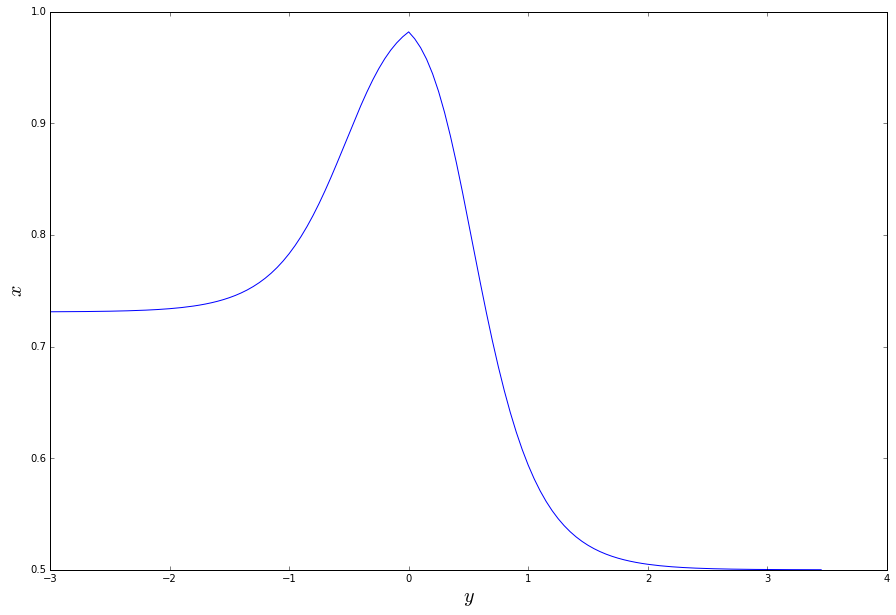

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(XT, yT)
plt.ylabel('$x$', size=20)
plt.xlabel('$y$', size=20)
plt.show()

Below, we want to select the appropiate parameters to the network:

In [16]:
alphas = [3.0, 1.5, 1.3, 1.0, 0.8, 0.7, 0.5, 0.3, 0.1, 0.03, 0.01]
epsilons = [10, 8, 7, 5, 3, 1, 0.8, 0.7, 0.5, 0.3, 0.1, 0.112]

In [17]:
bestE = {"alpha": 3.0, "epsilon": 10, "error":10.0}
epochs = 10
for alpha in alphas:
    for epsilon in epsilons:
        mlpE = MLP(neurons, functions, pfunctions)
        mlpE.setLink(1, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpE.setLink(2, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpE.setLink(3, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpE.setLink(2, 1, np.random.uniform(low=-epsilon, high=epsilon))
        mlpE.setLink(3, 1, np.random.uniform(low=-epsilon, high=epsilon))
        mlpE.setLink(4, 2, np.random.uniform(low=-epsilon, high=epsilon))
        mlpE.setLink(4, 3, np.random.uniform(low=-epsilon, high=epsilon))
        mlpE.setLink(4, 4, 1.0)
        fError = mlpE.fit(XT, yT, alpha, epochs, costFunction)[-1]
        
        if fError < bestE["error"]:
            bestE["alpha"] = alpha
            bestE["epsilon"] = epsilon
            bestE["error"] = fError

The best parameters found were:

In [18]:
print("Best alpha: ", bestE["alpha"])
print("Best epsilon: ", bestE["epsilon"])
print("Best error: ", bestE["error"])

Best alpha:  1.5
Best epsilon:  1
Best error:  0.00122406401947


With the previous parameter, we construct our network:

In [19]:
alpha = bestE["alpha"]
epsilon = bestE["epsilon"]
mlpE = MLP(neurons, functions, pfunctions)
mlpE.setLink(1, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpE.setLink(2, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpE.setLink(3, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpE.setLink(2, 1, np.random.uniform(low=-epsilon, high=epsilon))
mlpE.setLink(3, 1, np.random.uniform(low=-epsilon, high=epsilon))
mlpE.setLink(4, 2, np.random.uniform(low=-epsilon, high=epsilon))
mlpE.setLink(4, 3, np.random.uniform(low=-epsilon, high=epsilon))
mlpE.setLink(4, 4, 1.0)

Here, we want to present the initial weights of the network:

In [20]:
pd.DataFrame(mlpE.W)

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0
1,-0.205001,0.000000,0.000000,0.000000,0
2,0.582405,0.093151,0.000000,0.000000,0
3,-0.138762,-0.734739,0.000000,0.000000,0
4,0.000000,0.000000,-0.589175,0.477665,1


In [21]:
epochs = 10
error = mlpE.fit(XT, yT, alpha, epochs, costFunction)
print("Initial Error: ", error[0])
print("Final Error: ", error[-1])

Initial Error:  0.0169187421366
Final Error:  0.00586186648318


Next, we want to plot the error curve (evolution) during the training:

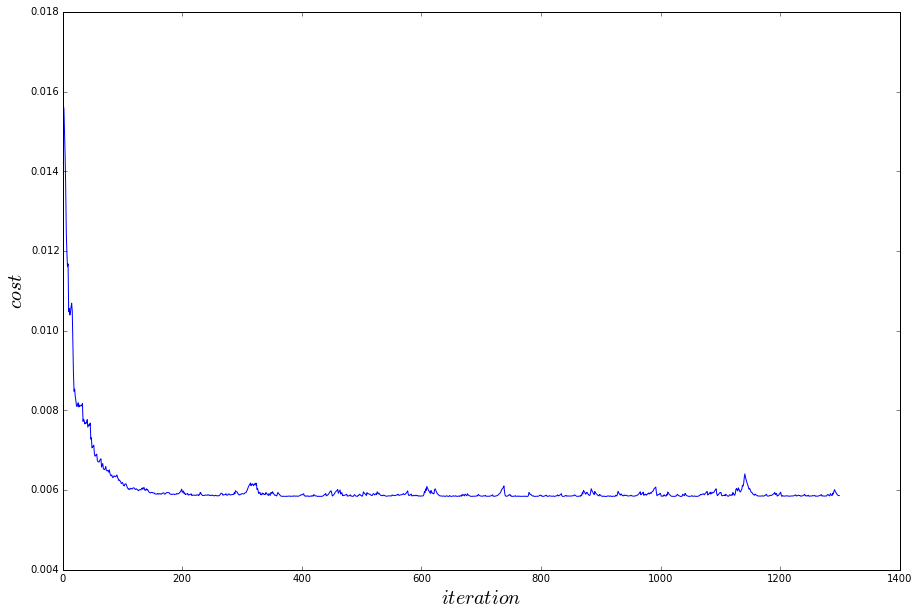

In [22]:
iteration = range(0, len(error))
plt.figure(figsize=(15, 10))
plt.plot(iteration, error)
plt.ylabel('$cost$', size=20)
plt.xlabel('$iteration$', size=20)
plt.show()

After that, we want to plot the calculated approximation by the neural network:

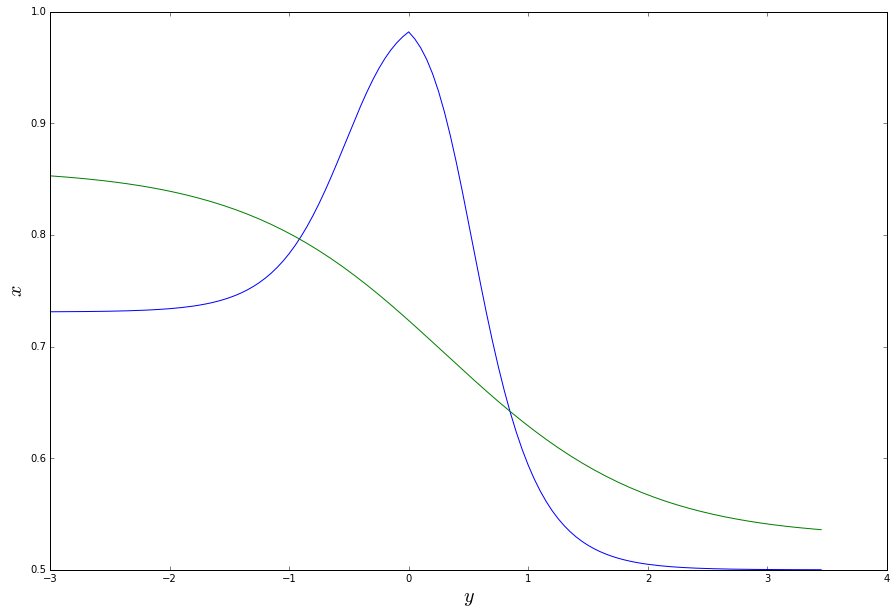

In [23]:
predE = []
for i in range(XT.shape[0]):
    predE.append(mlpE.forward(XT[i, :])[0])
    
plt.figure(figsize=(15, 10))
plt.plot(XT, yT)
plt.plot(XT, predE)
plt.ylabel('$x$', size=20)
plt.xlabel('$y$', size=20)
plt.show()

Then, we want to present the weights of the trained network:

In [24]:
pd.DataFrame(mlpE.W)

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0
1,-0.205001,0.000000,0.000000,0.000000,0
2,1.788346,0.093151,0.000000,0.000000,0
3,0.134748,-0.734739,0.000000,0.000000,0
4,0.000000,0.000000,-1.095413,0.355176,1


Finally, we want to try to approximate the function with a more complex network. Below, we want to select the appropiate parameters to the network:

In [25]:
fsF = [sigmoid] * 10 + [lambda x : x]
pfsF = [sigmoidPrime] * 10 + [lambda x : x]
fsF[3:6] = [relu, relu, relu]
pfsF[3:6] = [reluPrime, reluPrime, reluPrime]
bestF = {"alpha": 3.0, "epsilon": 10, "error":10.0}
epochs = 10

for alpha in alphas:
    for epsilon in epsilons:
        mlpF = MLP(11, fsF, pfsF)
        mlpF.setLink(1, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(2, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(3, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(3, 1, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(3, 2, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(4, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(4, 1, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(4, 2, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(5, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(5, 1, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(5, 2, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(6, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(6, 3, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(6, 4, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(6, 5, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(7, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(7, 3, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(7, 4, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(7, 5, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(8, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(8, 3, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(8, 4, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(8, 5, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(9, 0, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(9, 3, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(9, 4, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(9, 5, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(10, 6, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(10, 7, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(10, 8, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(10, 9, np.random.uniform(low=-epsilon, high=epsilon))
        mlpF.setLink(10, 10, 1.0)
        fError = mlpF.fit(XT, yT, alpha, epochs, costFunction)[-1]
        
        if fError < bestF["error"]:
            bestF["alpha"] = alpha
            bestF["epsilon"] = epsilon
            bestF["error"] = fError

The best parameters found were:

In [26]:
print("Best alpha: ", bestF["alpha"])
print("Best epsilon: ", bestF["epsilon"])
print("Best error: ", bestF["error"])

Best alpha:  1.5
Best epsilon:  5
Best error:  0.000184495151141


In [27]:
alpha = bestF["alpha"]
epsilon = bestF["epsilon"]
fsF = [sigmoid] * 10 + [lambda x : x]
pfsF = [sigmoidPrime] * 10 + [lambda x : x]

fsF[3:6] = [relu, relu, relu]
pfsF[3:6] = [reluPrime, reluPrime, reluPrime]

mlpF = MLP(11, fsF, pfsF)
mlpF.setLink(1, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(2, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(3, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(3, 1, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(3, 2, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(4, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(4, 1, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(4, 2, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(5, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(5, 1, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(5, 2, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(6, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(6, 3, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(6, 4, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(6, 5, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(7, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(7, 3, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(7, 4, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(7, 5, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(8, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(8, 3, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(8, 4, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(8, 5, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(9, 0, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(9, 3, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(9, 4, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(9, 5, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(10, 6, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(10, 7, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(10, 8, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(10, 9, np.random.uniform(low=-epsilon, high=epsilon))
mlpF.setLink(10, 10, 1.0)

The topology of this network is as follows:

In [28]:
print("Input neurons: ", mlpF.getInputNeurons())
print("Hidden neurons: ", mlpF.getHiddenNeurons())
print("Output neurons", mlpF.getOuputNeurons())

Input neurons:  [10]
Hidden neurons:  [1 2 3 4 5 6 7 8 9]
Output neurons [0]


In [29]:
epochs = 10
errorF = mlpF.fit(XT, yT, alpha, epochs, costFunction)
print("Initial Error: ", errorF[0])
print("Final Error: ", errorF[-1])

Initial Error:  0.187998058012
Final Error:  0.000201270730554


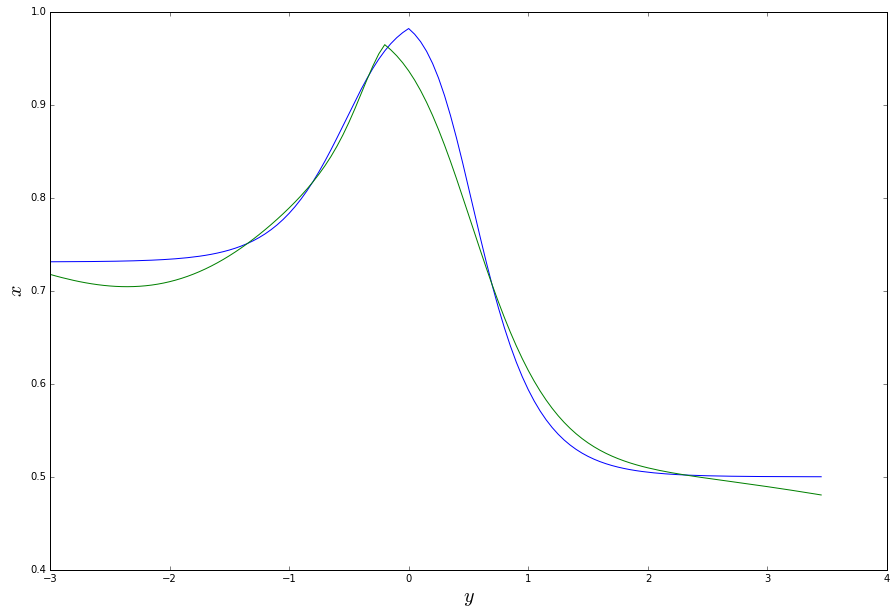

In [30]:
predF = []
for i in range(XT.shape[0]):
    predF.append(mlpF.forward(XT[i, :])[0])
    
plt.figure(figsize=(15, 10))
plt.plot(XT, yT)
plt.plot(XT, predF)
plt.ylabel('$x$', size=20)
plt.xlabel('$y$', size=20)
plt.show()

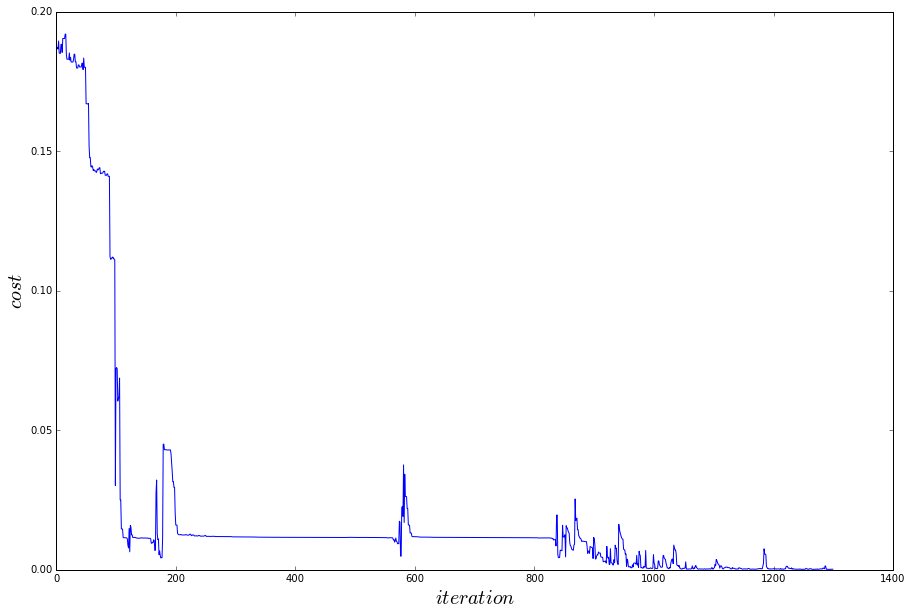

In [31]:
iteration = range(0, len(errorF))
plt.figure(figsize=(15, 10))
plt.plot(iteration, errorF)
plt.ylabel('$cost$', size=20)
plt.xlabel('$iteration$', size=20)
plt.show()

## 2. Bird classication.

In [2]:
modelAlexNet = "/home/fhdiaze/Models/bvlc_alexnet.caffemodeldel"
deployProtoTxt = "/home/fhdiaze/Models/deploy.prototxt"
birdsFolder = "/home/fhdiaze/Data/birds"
birdsLabels = os.listdir(birdsFolder)
imageNetLabels = np.loadtxt("/home/fhdiaze/Models/synset_words.txt", str, delimiter='\t')
splitSamples = np.loadtxt("/home/fhdiaze/Data/splitSamples.txt", str, delimiter=';')
cf.set_mode_gpu()

In [3]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=birdsLabels):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def loadSamples():
    labels = os.listdir(birdsFolder)
    dataset = np.empty((0,2))
    
    for label in labels:
        samples = sorted(os.listdir(os.path.join(birdsFolder, label)))
        for sample in samples:
            path = os.path.join(birdsFolder, label, sample)
            if os.path.isfile(path):
                dataset = np.concatenate((dataset, np.array([[label, path]])), axis=0)
                
    return dataset

In [5]:
def predict(net, samples):
    pred = np.empty((0,1), dtype=int)
    outputLfc6 = np.empty((0,4096))
    outputLfc7 = np.empty((0,4096))
    transformer = cf.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_mean('data', np.load('/opt/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    
    for sample in samples:
        net.blobs['data'].data[...] = transformer.preprocess('data', cf.io.load_image(sample[1]))
        out = net.forward()
        pred = np.concatenate((pred, [net.blobs['prob'].data[0].flatten().argsort()[-1:-2:-1]]))
        outputLfc6 = np.concatenate((outputLfc6, [net.blobs['fc6'].data[0]]))
        outputLfc7 = np.concatenate((outputLfc7, [net.blobs['fc7'].data[0]]))
    
    return pred, outputLfc6, outputLfc7

### (a) Download the dataset birds from http://www-cvr.ai.uiuc.edu/ponce grp/data/.

The birds database was downloaded correctly. The database has six hundred images, where every 100 images represent every one the six species, as follows:

In [6]:
os.listdir(birdsFolder)

['wood_duck', 'egret', 'owl', 'toucan', 'puffin', 'mandarin']

### (b) Use $Caffe$ and the AlexNet pre-trained model, to classify the images in the birds dataset. Construct a confusion matrix that relates the bird classes with the 10 most frequent classes from ImageNet predicted by the model.

After downloading the Caffe and AlexNet pre-trained files, we use the AlexNet to classify the images in the birds dataset (600 images), with the parameters that this network had, after this one have learned using the one million (1'000.000) of imageNet images.  

In [7]:
alexNet = cf.Net(deployProtoTxt, modelAlexNet, cf.TEST)

In [1]:
sol

NameError: name 'alexNet' is not defined

In [9]:
samples = loadSamples()

In [10]:
YPredAlexNet, XLfc6, XLfc7 = predict(alexNet, samples)

Then, we construct a confusion matrix that relates the ten most frequent classes of birds from ImageNet predicted by the model as follows:

In [11]:
classes, indices = np.unique(YPredAlexNet, return_inverse=True)
classesIds = classes[np.argsort(np.bincount(indices))[-1:-11:-1]]
counts = np.sort(np.bincount(indices))[-1:-11:-1]
classesNames = imageNetLabels[classesIds]
pd.DataFrame(np.matrix([classesIds, classesNames, counts]).T, columns=["$Id$", "$Name$", "$Quantity$"])

,$Id$,$Name$,$Quantity$
0,97,n01847000 drake,164
1,96,n01843383 toucan,108
2,132,"n02009912 American egret, great white heron, E...",84
3,81,n01796340 ptarmigan,20
4,99,n01855672 goose,16
5,143,"n02037110 oystercatcher, oyster catcher",15
6,87,"n01817953 African grey, African gray, Psittacu...",13
7,146,"n02058221 albatross, mollymawk",13
8,21,n01608432 kite,12
9,89,"n01819313 sulphur-crested cockatoo, Kakatoe ga...",10


Next, we want to select the examples that belong to the top ten most frequent classes:

In [12]:
samplesInTopTenClasses = np.where(YPredAlexNet == classesIds)[0]

Now, we compute the confusion matrix:

In [13]:
yTrue = samples[samplesInTopTenClasses, 0]
yPred = imageNetLabels[YPredAlexNet[samplesInTopTenClasses, 0]]
allLabels = list(set(list(yTrue) + list(yPred)))
CM = confusion_matrix(yTrue, yPred, labels=allLabels)
print CM

[[ 0  0  0  0  1  1  0  0  0  0  0  0  0  0  0 84]
 [ 0  0  0 19  0  9  0 12  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 84  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 12  0  8  1 12  4  0  0 15 13  0  0]
 [ 0  0  0  0  0  0  0  0 96  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 72  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


Finally, we plot the confusion matrix with a colorbar to a better representation:

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


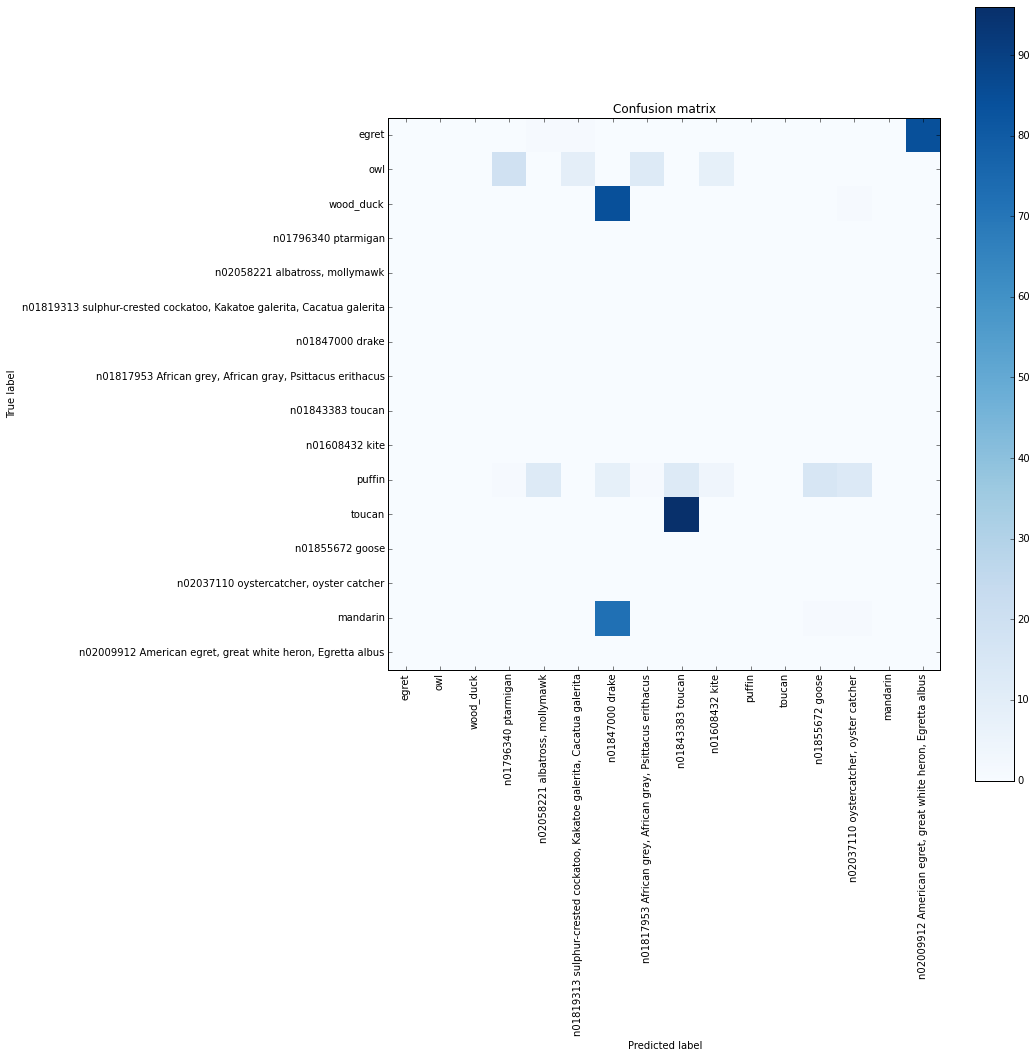

In [14]:
plt.figure(figsize=(15, 15))
plot_confusion_matrix(CM, labels=allLabels)

    ### (c) Use $Caffe$ and the AlexNet pre-trained model to extract features for all the images in the bird dataset. Use the output of the 'fc6' layer. Train a linear classiffer (logistic regression or linear svm) and evaluate it, using the train, validation and test partitions suggested for the dataset.

At this point, we have preprocessed file "http://www-cvr.ai.uiuc.edu/ponce_grp/data/birds/birds_f_numbers.txt", and after that, we have obtained the next matrix (Some samples are presented):

In [15]:
splitSamples[:10, :]

array([['Wood duck', 'Egret', 'Owl', 'Toucan', 'Puffin ', 'Mandarin'],
       ['47', '18', '6', '91', '100', '24'],
       ['19', '75', '70', '11', '80', '92'],
       ['90', '29', '69', '46', '15', '31'],
       ['61', '57', '15', '77', '22', '8'],
       ['82', '71', '61', '35', '23', '42'],
       ['99', '22', '46', '79', '13', '21'],
       ['96', '23', '50', '22', '19', '99'],
       ['80', '20', '56', '64', '68', '91'],
       ['73', '79', '84', '49', '12', '25']], 
      dtype='|S9')

So, we may handle the dataset by class, such as subset and after that, we may use the recommendations by the authors: 

*"The first 20 files in the list were used for training 
%% (see birds_training_pairs.txt for lists of training pairs), 
%% the next 30 for validation, and the final 50 for testing."*

In [16]:
woodSamples = np.array(splitSamples[1:, 0], dtype=int) -1
egretSamples = 100*1 + np.array(splitSamples[1:, 1], dtype=int) - 1
owlSamples = 100*2 + np.array(splitSamples[1:, 2], dtype=int) - 1
toucanSamples = 100*3 + np.array(splitSamples[1:, 3], dtype=int) - 1
puffinSamples = 100*4 + np.array(splitSamples[1:, 4], dtype=int) - 1
mandarinSamples = 100*5 + np.array(splitSamples[1:, 5], dtype=int) - 1

In [17]:
trainIdx = np.concatenate((
        woodSamples[0:20],
        egretSamples[0:20],
        owlSamples[0:20],
        toucanSamples[0:20],
        puffinSamples[0:20],
        mandarinSamples[0:20],
        ))

crossIdx = np.concatenate((
        woodSamples[20:50],
        egretSamples[20:50],
        owlSamples[20:50],
        toucanSamples[20:50],
        puffinSamples[20:50],
        mandarinSamples[20:50],
        ))

testIdx = np.concatenate((
        woodSamples[50:100],
        egretSamples[50:100],
        owlSamples[50:100],
        toucanSamples[50:100],
        puffinSamples[50:100],
        mandarinSamples[50:100],
        ))

In [18]:
XTrainLfc6 = XLfc6[trainIdx]
yTrainLfc6 = samples[trainIdx, 0]
XCrossLfc6 = XLfc6[crossIdx]
yCrossLfc6 = samples[crossIdx, 0]
XTestLfc6 = XLfc6[testIdx]
yTestLfc6 = samples[testIdx, 0]

In [19]:
linSvmLfc6 = svm.LinearSVC()
linSvmLfc6.fit(XTrainLfc6, yTrainLfc6)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [20]:
yPredSvmLfc6 = linSvmLfc6.predict(XTestLfc6)

In [21]:
CMSvmLfc6 = confusion_matrix(yTestLfc6, yPredSvmLfc6, labels=birdsLabels)

After then, we may plot the confusion matrix to get a better representation about the classifier response:

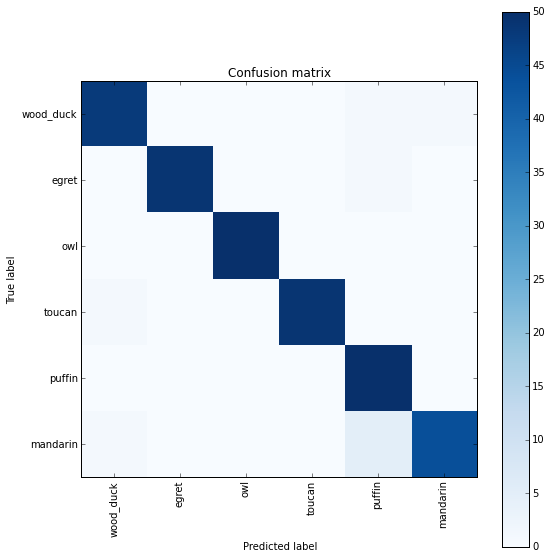

In [22]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix(CMSvmLfc6, labels=birdsLabels)

In [23]:
print(classification_report(yTestLfc6, yPredSvmLfc6))

             precision    recall  f1-score   support

      egret       1.00      0.98      0.99        50
   mandarin       0.98      0.88      0.93        50
        owl       1.00      1.00      1.00        50
     puffin       0.88      1.00      0.93        50
     toucan       1.00      0.98      0.99        50
  wood_duck       0.96      0.96      0.96        50

avg / total       0.97      0.97      0.97       300



In [24]:
accuracy_score(yTestLfc6, yPredSvmLfc6)

0.96666666666666667

We can observe at the previous table that the classification has a high accuracy ($96.7\%$), presented a few of error between puffin and mandarin, due to the similaritude among these birds.

### (d) Repeat the previous step, but this time using as features the output of the 'fc7' layer. Compare and discuss.

In [25]:
XTrainLfc7 = XLfc7[trainIdx]
yTrainLfc7 = samples[trainIdx, 0]
XCrossLfc7 = XLfc7[crossIdx]
yCrossLfc7 = samples[crossIdx, 0]
XTestLfc7 = XLfc7[testIdx]
yTestLfc7 = samples[testIdx, 0]

In [26]:
linSvmLfc7 = svm.LinearSVC()
linSvmLfc7.fit(XTrainLfc7, yTrainLfc7)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [27]:
yPredSvmLfc7 = linSvmLfc7.predict(XTestLfc7)

In [28]:
CMSvmLfc7 = confusion_matrix(yTestLfc7, yPredSvmLfc7, labels=birdsLabels)

After then, we may plot the confusion matrix to get a better representation about the classifier response:

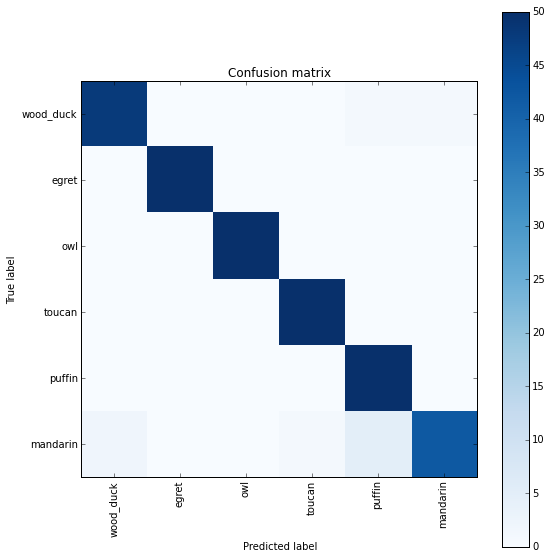

In [29]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix(CMSvmLfc7, labels=birdsLabels)

In [30]:
print(classification_report(yTestLfc7, yPredSvmLfc7))

             precision    recall  f1-score   support

      egret       1.00      1.00      1.00        50
   mandarin       0.98      0.84      0.90        50
        owl       1.00      1.00      1.00        50
     puffin       0.89      1.00      0.94        50
     toucan       0.98      1.00      0.99        50
  wood_duck       0.96      0.96      0.96        50

avg / total       0.97      0.97      0.97       300



In [31]:
accuracy_score(yTestLfc7, yPredSvmLfc7)

0.96666666666666667

We may observe at the previous table that the classification has a high accuracy about ($97\%$). The response of the classifiers used in fc6 and fc7 are too similar, both with num_output: 4096, although the results expected that fc7 should discriminate and differentiate better among all the classes, due to the additional relu7 and drop7 that improve his performance, the classifier found no significant difference between themwith this dataset.

Finally we want to show the differerences between the features of $fc6$ and $fc7$, as you can see the features have a big numerical difference but grapically the difference is not significant, so the linear classifier does not found a big better performance

In [36]:
np.sum(XLfc7[300, :] - XLfc6[300, :])

-4023.3989115282893

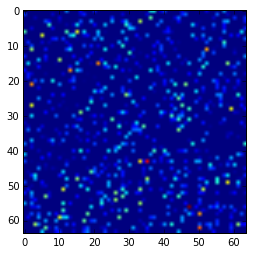

In [37]:
plt.imshow(np.reshape(XLfc6[300, :], (64, 64)))
plt.show()

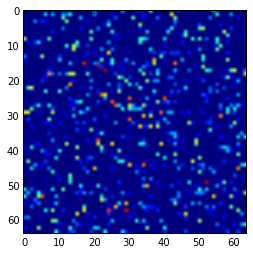

In [38]:
plt.imshow(np.reshape(XLfc7[300, :], (64, 64)))
plt.show()

### 3. RICA autoencoder

## (a) Download the code from https://github.com/jatinshah/ufldl_tutorial and run both train.py and softma_exercise.py, which solve the exercises in http://ufldl.stanford.edu/wiki/index.php/Exercise:Vectorization  and http://ufldl.stanford.edu/wiki/index.php/Exercise:Softmax_Regression respectively. Discuss the results.

The codes were downloaded of the previous link. The files with the images and labels were computed with gunzip due to the tgz extension. The train.py (Vectorization) was an autoencoder as shown in the next figure and presented the following results with a runtime about 50 min at lisi server of Mindlab.

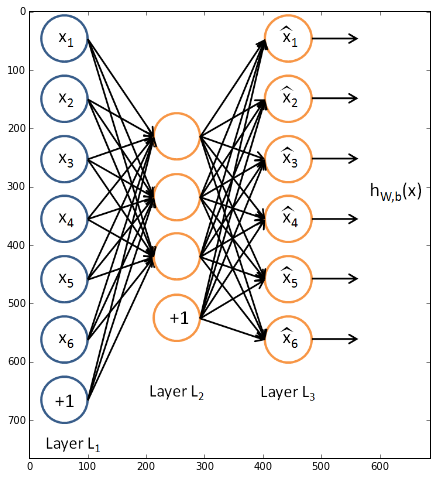

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
img = plt.imread('Data/Autoencoder.png')
plt.figure(figsize=(10, 8))
imgplot = plt.imshow(img)

After 400 iterations of updates, the autoencoder have learned features that resemble pen strokes. The autoencoder may to represent handwritten characters in terms of what pen strokes appear in an image. The results are visualized at the following image: 

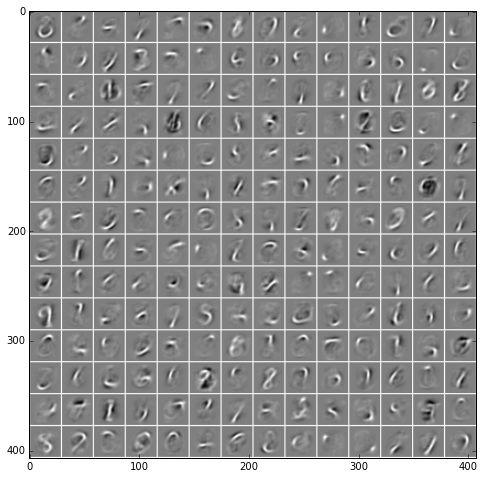

In [5]:
img = plt.imread('Data/weights_autoencoder.png')
plt.figure(figsize=(10, 8))
imgplot = plt.imshow(img)

By examing the hidden units (196), we may try to extrapole that each hidden units is learning. Every square shows the edge detection at diffferent possitions and orientatios in the images to the 196 hidden units.

On the other hand, the softmax_exercise.py (Softmax regression) presented an runtime less at 5 min at lisi server of Mindlab. 
The code loads the train and test data, adding an intercept term, used minFunc with the softmax regression as the objective function.

After trained the model with the images and labels, the model was tested against the MNIST test set, comprising 10000 28x28 images. 
The code generates predictions for input data under a trained softmax model, training on the full 60000 training images. The final testing to compute the accuracy (the proportion of correctly classified images) of your model using the MNIST dataset (10 digits). Our implementation achieved an accuracy of 92.4%.

## (b) Modify the code to train a Restricted Independent Component Analysis (RICA) model instead of a sparse autoencoder. The objective function of RICA is as follows:

## $$min_{W} \hspace{1cm}\mathbf{\lambda}{\lVert {\mathbf{Wx}}\rVert}_1 + \frac{1}{2}{\lVert {\mathbf{W^TWx -x}}\rVert}_{2}^{{2}}$$

## Use the following approximation  for an $\epsilon$ small enough

$${\lVert {\mathbf{y}}\rVert}_1\approx \mathbf{\text{Σ}}_{i}\mathbf{\sqrt{{y_{i}^{2}}+ \mathbf{\epsilon}}}$$

The modification from the sparse autoencoder to the Restricted Independent Component Analysis (RICA) need the following steps to implement the RICA cost and gradient:

1. To find the weights and activation functions of the network:

Layer|Weigh|Activation function
-|-|-
1|$W$|$f(z_i)=z_i$      
2|$W^T$|$f(z_i)=z_i$  
3|$WW^T$|$f(z_i)=z_i - xi$
4|$N/A$|$f(z_i)=z_i^2$

In [2]:
# Loading 10K images from MNIST database
images = load_MNIST.load_MNIST_images('/home/ojperdomoc/ML_TAR4/train-images-idx3-ubyte')
data = images[:, 0:10000]

visible_size = 28 * 28
# number of input units
hidden_size = 196
# desired average activation of the hidden units.
epsilon_ = np.finfo(float).eps
# weight decay parameter
lambda_ = 3e-3

#  Obtain random parameters theta
theta = sparse_RICA.initialize(hidden_size, visible_size)

r = np.sqrt(6) / np.sqrt(hidden_size + visible_size + 1)
#W1 = np.random.random((hidden_size, visible_size)) * 2 * r - r
#theta = W1.reshape(hidden_size * visible_size)

W1 = np.random.random((hidden_size, visible_size)) * 2 * r - r
Wold = W1
W1 = W1/np.sqrt(np.sum((W1**2) + epsilon_))
theta = W1.reshape(hidden_size * visible_size)

W1 = theta[0:hidden_size * visible_size].reshape(hidden_size, visible_size)
epsilon_ = np.finfo(float).eps
    
# Number of training examples
m = data.shape[1]

# Forward propagation
a2 = W1.dot(data)
z3 = W1.T.dot(a2)
z4 = z3 - data
h1= z4**2
    
# Cost function
cost = np.sum((h1 / 2) + (lambda_ * (np.sum(np.sqrt(a2 ** 2) + epsilon_))))
print cost

863384508.592


The final expression $J(z^{(4)})=F(x)=\mathbf{\text{Σ}}_{k}J(z_{k}^{4})$
where, the gradient with respect to $W$ is simply the sum of gradients for each instance of $W$ in the network.

Layer|Derivative_f'|Delta activation|Input_z to this layer
-|-|-|-
4|$f'(z_i)=2z_i$|$f'(z_i)=2z_i$|$(W_TWx - x)$      
3|$f'(z_i)=1$|$(I^T\mathbf{\delta}^{(4)}).1$|$W_TWx$ 
2|$f'(z_i)=1$|$((W^T)^T\mathbf{\delta}^{(3)}).1$|$Wx$ 
1|$f'(z_i)=1$|$W^T\mathbf{\delta}^{(2)}.1$|$(W_TWx - x)$ 

In [3]:
delta4 = 2*z4
delta3 = W1.T.dot(W1).dot(delta4)
delta2 = W1.dot(delta3)
delta1 = W1.transpose().dot(delta2)
W2grad = delta4.dot(a2.transpose())
W1grad = (W1.dot(delta4)).dot(data.transpose())
    
# After computing the cost and gradient, we will convert the gradients back
# to a vector format (suitable for minFunc).  Specifically, we will unroll
# your gradient matrices into a vector.
grad = (W1grad + W2grad.transpose()).reshape(hidden_size * visible_size)
print grad

[-0.10033704 -0.00309259  0.05069013 ...,  0.13348212 -0.05592929
 -0.10789755]


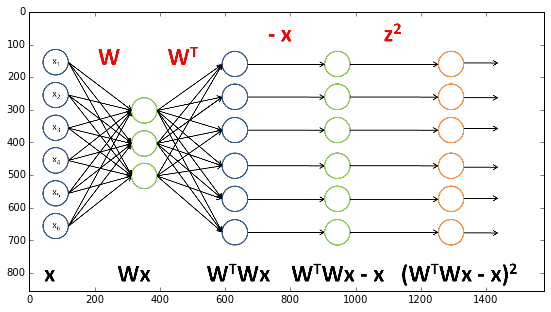

In [4]:
img = plt.imread('Data/RICA.png')
plt.figure(figsize=(10, 5))
imgplot = plt.imshow(img)

## (c) Repeat item (a) with the new code. Compare and discuss.

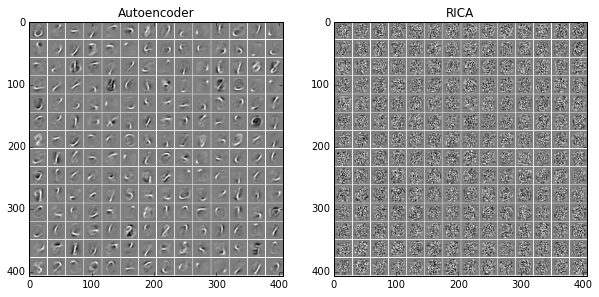

In [5]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
ax1, ax2 = axes.ravel()
imgauto_rica=mpimg.imread('Data/weights_autoencoder.png')
ax1.imshow(imgauto_rica)
ax1.set_title('Autoencoder')
imgauto_rica=mpimg.imread('Data/weights_rica.png')
ax2.imshow(imgauto_rica)
ax2.set_title('RICA')

The difference between the sparse autoencoder and RICA, the RICA has not sparsity and bias parameters comparing to autoencoder. The time of execution at the RICA of the code is 8 times faster that autoencoder and works well in practce.

The reconstructive penalty from the auto-encoder acts as a degeneracy control by the use of Kullback-Leibler (KL), instead, the reconstructive penalty from the RICA represents with a soft reconstruction penalty taht ensure that the filter matrix does not learn copies or redundant features. 

Thus we can see that RICA in the over-complete case is the same as a sparse autoencoder with an L1 sparsity constraint and without non-linearity (sigmoid function used at autoencoders). This allows RICA to scale to over-complete basis and be optimized with backprop like sparse auto-encoders, being more robust to non-whitened data instead auto-encoder behavior.

# Norm ball projection: 
In order to learn an overcomplete representation without degenerate(zero) features, we constrain each row of W to have a L2. Although these constraints prevent learning degenerate representations, they make the optimization problem potentially harder and requiere the use of projected gradient methods. The steps to compute a RICA for a large overcomplete representations as follows:

Step1 (Projection):
$$\hat{W}_{ij}=\frac{{W_{ij}}}{{\mathbf{\sqrt{{\mathbf{\text{Σ}}_{l=1}^{n}W_{il}^{2}}+ \mathbf{\epsilon}}}}}, \forall_{i}=1,...,k.$$

Step2: Compute gradient $g$ using $\hat{W}$.

Step3 (Inverse Projection):
$$g_{ij}=\frac{g_{ij}}{\mathbf{\sqrt{{\mathbf{\text{Σ}}_{l=1}^{n}W_{il}^{2}}+ \mathbf{\epsilon}}}}-\hat{W}_{ij}\frac{\mathbf{\text{Σ}}_{l=1}^{n}g_{il}{W}_{il}}{\mathbf{\epsilon}+\mathbf{\text{Σ}}_{l=1}^{n}W_{il}^{2}}$$

In [7]:
    W1 = theta[0:hidden_size * visible_size].reshape(hidden_size, visible_size)
    epsilon_ = np.finfo(float).eps
    Wold = W1
    W1 = W1/np.sqrt(np.sum((W1**2) + epsilon_))
    #Wold = theta[hidden_size * visible_size:2 * hidden_size * visible_size].reshape(hidden_size, visible_size)
    # Number of training examples
    m = data.shape[1]

    # Forward propagation
    z2 = W1.dot(data)
    a2 = W1.dot(data)
    z3 = W1.T.dot(a2)
    h = W1.T.dot(a2)
    z4 = h - data
    h1= z4**2

    # Cost function
    lambda_ = 3e-3
    cost = np.sum(h1 / 2) + (lambda_*(np.sum(np.sqrt((a2 ** 2) + epsilon_))))

    # Backprop
    delta4 = 2*z4
    delta3 = W1.T.dot(W1).dot(delta4)
    delta2 = W1.dot(delta3)
    delta1 = W1.transpose().dot(delta2)
    W2grad = delta4.dot(z2.transpose())
    W1grad = (W1.dot(delta4)).dot(data.transpose())
    
    # After computing the cost and gradient, we will convert the gradients back
    # to a vector format (suitable for minFunc).  Specifically, we will unroll
    # your gradient matrices into a vector.
    grad = (W1grad + W2grad.transpose())
    l2rows = np.sqrt(np.sum(Wold**2)+epsilon_)
    y = Wold/l2rows
    grad = (grad/l2rows-(y*(np.sum(grad*Wold))/np.sqrt(l2rows)))

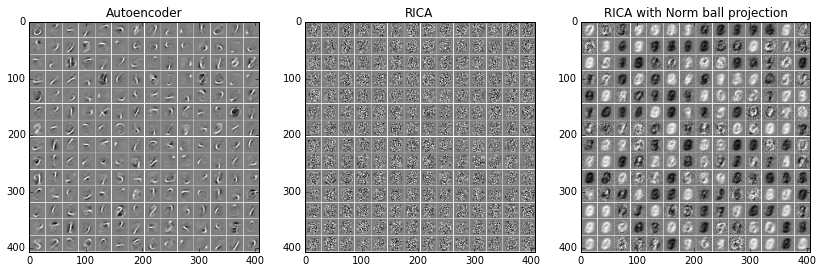

In [8]:
fig, axes = plt.subplots(1,3, figsize=(14,8))
ax1, ax2, ax3 = axes.ravel()
imgauto_rica1=mpimg.imread('Data/weights_autoencoder.png')
ax1.imshow(imgauto_rica1)
ax1.set_title('Autoencoder')
imgauto_rica1=mpimg.imread('Data/weights_rica.png')
ax2.imshow(imgauto_rica1)
ax2.set_title('RICA')
imgauto_rica1=mpimg.imread('Data/weightsRicaNB.png')
ax3.imshow(imgauto_rica1)
ax3.set_title('RICA with Norm ball projection')

RICA with norm ball projection outperformed both runtime (about 1 minute) and learn not redundant features, which ensure a robust and simple strategy to withdraw some problems presented in RICA.